### Import modules

In [6]:
"""This file is meant to explore and visualize the key takeaways from the paris bike
accident database found at the following link :
UPDATE LINK
https://www.data.gouv.fr/fr/datasets/comptage-velo-donnees-compteurs/"""

# Import section
import pandas as pd
import datetime
import numpy as np

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

### Import accident data

In [8]:
df = pd.read_csv("df_velos_merged.csv")

C:\Users\USER\AppData\Local\Temp\ipykernel_10484\3685739879.py:1: DtypeWarning: Columns (15,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_velos_merged.csv")


In [9]:
df.head()

,Unnamed: 0,date,mois,jour,heure,departement,commune,lat,lon,en agglomeration,...,existence securite,usage securite,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules
0,200500000030,2005-01-13 00:00:00,01 - janvier,3 - jeudi,19.0,62,62331,50.300,2.840,oui,...,NaN,NaN,NaN,Véhicule,Côté gauche,Changeant de file à gauche,200500000030B02,Transport en commun,Dépassant à gauche,1.0
1,200500000034,2005-01-19 00:00:00,01 - janvier,2 - mercredi,10.0,62,62022,0.000,0.000,non,...,NaN,NaN,NaN,Véhicule,Avant,Sans changement de direction,200500000034B02,"VU seul 1,5T <= PTAC <= 3,5T avec ou sans remo...",Tournant à gauche,1.0
2,200500000078,2005-01-26 00:00:00,01 - janvier,2 - mercredi,13.0,02,02173,0.000,0.000,non,...,Casque,Non,NaN,Véhicule,Avant,Sans changement de direction,200500000078B02,VL seul,Tournant à gauche,1.0
3,200500000093,2005-01-03 00:00:00,01 - janvier,0 - lundi,13.0,02,02810,49.255,3.094,oui,...,NaN,NaN,NaN,Véhicule,Avant gauche,Manœuvre d’évitement,200500000093B02,VL seul,Manœuvre d’évitement,1.0
4,200500000170,2005-01-29 00:00:00,01 - janvier,5 - samedi,18.0,76,76196,0.000,0.000,non,...,Autre,Oui,NaN,Véhicule,Arrière,"Même sens, même file",200500000170A01,"VU seul 1,5T <= PTAC <= 3,5T avec ou sans remo...","Même sens, même file",1.0


### Clean data

In [10]:
# Rename column names

def under(str):
    return(str.replace(" ", "_"))
renamed = dict(zip(df.columns, df.columns.map(under)))
df.rename(columns = renamed, inplace=True)

# Set ID as index

df.set_index("Unnamed:_0", inplace=True)

In [11]:
# Convert datafields to their appropriate datatypes
def clean_date(string):
    try:
        return(pd.to_datetime(string[:-6], format = "%Y-%d-%m"))
    except:
        try:
            return(pd.to_datetime(string[:-6], format = "%Y-%m-%d"))
        except:
            return(pd.to_datetime(string, format = "%Y-%d-%m"))
    
df["clean_date"] = df["date"].apply(clean_date)

df["clean_date"] = df["clean_date"] + pd.to_timedelta(df["heure"], unit="h")

df.drop(columns = ["date"], inplace=True)
df.rename(columns={"clean_date": "date"}, inplace=True)

In [12]:
dico = {"Indemne" : 0, "Blessé léger" : 1, "Blessé hospitalisé " : 2, "Tué" : 3, "0 - Indemne" : 0,
       "1 - Blessé léger" : 1, "2 - Blessé hospitalisé" : 2, "3 - Tué" : 3, "Non renseigné" : -1}


dico_situation = {"Sur chaussée" : False, "Sur piste cyclable": True, "Sur trottoir" : False,
"Sur autre voie spéciale" : False, "Sur accotement" : False,
"Sur bande d’arrêt d’urgence" : False, "Autres" : False}

In [13]:
df["jour"] = df["jour"].apply(lambda x: x[0])
df["age"] = df["age"].astype("str").apply(lambda x : x.split("-", 1)[0])
df["age"] = df["age"].replace(np.nan, 0)
df["gravite_accident"] = df["gravite_accident"].replace(dico)
df["piste_cyclable"] = df["situation"].replace(dico_situation)

In [14]:
numerical_features = ["lat", "lon", "nb_voies", "largeur_TPC", "largeur_route", "nombre_autres_vehicules",
                      "jour", "gravite_accident", "age"]
boolean_features = ["en_agglomeration", "usage_securite"]
categorical_features = ["departement", "commune"]

for col in numerical_features :
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
for col in categorical_features :
    df[col] = df[col].astype("category")

for col in boolean_features :
    df[col] = df[col].str.lower().map({'oui':True ,'non':False})
    
# Drop useless fields

to_drop = ["mois", "heure"]
df.drop(to_drop, inplace=True, axis=1)

In [15]:
print(df.columns)

Index(['jour', 'departement', 'commune', 'lat', 'lon', 'en_agglomeration',
       'type_intersection', 'type_collision', 'luminosite',
       'conditions_atmosperiques', 'type_route', 'circulation', 'nb_voies',
       'profil_long_route', 'trace_plan_route', 'largeur_TPC', 'largeur_route',
       'etat_surface', 'amenagement', 'situation', 'categorie_usager',
       'gravite_accident', 'sexe', 'age', 'motif_deplacement',
       'existence_securite', 'usage_securite', 'obstacle_fixe_heurte',
       'obstacle_mobile_heurte', 'localisation_choc',
       'manoeuvre_avant_accident', 'identifiant_vehicule',
       'type_autres_vehicules', 'manoeuvre_autres_vehicules',
       'nombre_autres_vehicules', 'date', 'piste_cyclable'],
      dtype='object')


### Focus on Paris values

In [16]:
df.shape

(81617, 37)

In [17]:
df = df.loc[df["departement"]=="75"]

In [18]:
df.shape

(12902, 37)

### Explore numeric features

In [19]:
df.describe()

,jour,lat,lon,nb_voies,largeur_TPC,largeur_route,gravite_accident,age,nombre_autres_vehicules
count,12902.000000,12902.000000,12902.000000,12129.000000,988.000000,9509.000000,12864.000000,9786.000000,10623.000000
mean,2.742676,19.491499,0.935355,2.339682,51.636640,68.098012,0.934701,36.094318,0.964982
std,1.968035,23.926323,1.148444,1.356131,66.557975,59.424203,0.443421,14.890546,0.354514
min,0.000000,0.000000,0.000000,-1.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,10.000000,25.000000,1.000000,25.000000,1.000000
50%,2.000000,0.000000,0.000000,2.000000,22.500000,60.000000,1.000000,33.000000,1.000000
75%,4.000000,48.853458,2.335249,3.000000,78.000000,100.000000,1.000000,46.000000,1.000000
max,9.000000,48.901300,2.464630,28.000000,700.000000,770.000000,3.000000,95.000000,7.000000


### Explore nan values

In [20]:
for col in df.columns:
    print(col, df[col].isna().sum())

jour 0
departement 0
commune 0
lat 0
lon 0
en_agglomeration 3113
type_intersection 0
type_collision 0
luminosite 0
conditions_atmosperiques 0
type_route 0
circulation 9789
nb_voies 773
profil_long_route 314
trace_plan_route 878
largeur_TPC 11914
largeur_route 3393
etat_surface 256
amenagement 9109
situation 508
categorie_usager 38
gravite_accident 38
sexe 38
age 3116
motif_deplacement 1924
existence_securite 1249
usage_securite 7284
obstacle_fixe_heurte 9596
obstacle_mobile_heurte 1601
localisation_choc 1357
manoeuvre_avant_accident 246
identifiant_vehicule 38
type_autres_vehicules 2279
manoeuvre_autres_vehicules 2460
nombre_autres_vehicules 2279
date 151
piste_cyclable 508


In [21]:
to_drop = ["circulation", "amenagement", "usage_securite", "obstacle_fixe_heurte", "largeur_TPC", "largeur_route", "situation",
            "lat", "lon"
]
df = df.drop(columns = to_drop)

In [22]:
to_drop_macro = ["en_agglomeration", 'motif_deplacement', "existence_securite",
                 "obstacle_mobile_heurte", "localisation_choc", "manoeuvre_autres_vehicules",
                "type_autres_vehicules", "manoeuvre_avant_accident", "profil_long_route",
                "etat_surface", "trace_plan_route", "nombre_autres_vehicules"]
df = df.drop(columns = to_drop_macro)

In [23]:
for col in df.columns:
    print(col, df[col].isna().sum())

print(df.shape)
df.head()

jour 0
departement 0
commune 0
type_intersection 0
type_collision 0
luminosite 0
conditions_atmosperiques 0
type_route 0
nb_voies 773
categorie_usager 38
gravite_accident 38
sexe 38
age 3116
identifiant_vehicule 38
date 151
piste_cyclable 508
(12902, 16)


,jour,departement,commune,type_intersection,type_collision,luminosite,conditions_atmosperiques,type_route,nb_voies,categorie_usager,gravite_accident,sexe,age,identifiant_vehicule,date,piste_cyclable
Unnamed:_0,,,,,,,,,,,,,,,,
200500004591,1,75,75001,Hors intersection,Deux véhicules - par le coté,Nuit avec éclairage public allumé,Normale,Voie Communale,2.0,Conducteur,1.0,M,36.0,200500004591B01,2005-01-04 17:00:00,False
200500004597,0,75,75005,Intersection en X,Deux véhicules - par l’arrière,Plein jour,Normale,Voie Communale,3.0,Conducteur,0.0,M,26.0,200500004597A01,2005-01-03 09:00:00,False
200500004600,0,75,75019,Intersection en T,Autre,Nuit avec éclairage public allumé,Normale,Voie Communale,4.0,Conducteur,0.0,M,31.0,200500004600A01,2005-01-03 17:00:00,False
200500004627,2,75,75007,Intersection en T,Deux véhicules - par le coté,Nuit avec éclairage public allumé,Pluie légère,Voie Communale,2.0,Conducteur,1.0,M,57.0,200500004627A01,2005-01-05 18:00:00,False
200500004630,2,75,75013,Intersection en T,Deux véhicules - par le coté,Plein jour,Pluie légère,Voie Communale,4.0,Conducteur,1.0,F,26.0,200500004630B01,2005-01-05 08:00:00,False


In [24]:
df = df.dropna()

In [25]:
df.shape

(8471, 16)

### Categorical features

In [26]:
df["arrondissement"] = df["commune"].apply(lambda x : x[-2:])

In [27]:
other_cat = ["departement", "type_intersection", "type_collision",
             "identifiant_vehicule", "date", "commune"]

In [28]:
df.drop(columns = other_cat, inplace=True)
df.columns

Index(['jour', 'luminosite', 'conditions_atmosperiques', 'type_route',
       'nb_voies', 'categorie_usager', 'gravite_accident', 'sexe', 'age',
       'piste_cyclable', 'arrondissement'],
      dtype='object')

### Preprocessing

In [29]:
## One hot encoding when needed

In [30]:
one_hot = ["luminosite", "type_route", "conditions_atmosperiques",
           "categorie_usager", "sexe", "arrondissement", "piste_cyclable"]
df_one_hot = df[one_hot]

In [31]:
df_one_hot = pd.get_dummies(df_one_hot)
df = pd.concat([df, df_one_hot], axis=1)
df = df.drop(one_hot, axis = 1)

In [32]:
## Scaling our data

In [33]:
df.columns

Index(['jour', 'nb_voies', 'gravite_accident', 'age',
       'luminosite_Crépuscule ou aube',
       'luminosite_Nuit avec éclairage public allumé',
       'luminosite_Nuit avec éclairage public non allumé',
       'luminosite_Nuit sans éclairage public', 'luminosite_Plein jour',
       'type_route_Autre', 'type_route_Hors réseau public',
       'type_route_Parc de stationnement ouvert à la circulation publique',
       'type_route_Route Départementale', 'type_route_Route Nationale',
       'type_route_Voie Communale', 'conditions_atmosperiques_Autre',
       'conditions_atmosperiques_Brouillard - fumée',
       'conditions_atmosperiques_Neige - grêle',
       'conditions_atmosperiques_Normale',
       'conditions_atmosperiques_Pluie forte',
       'conditions_atmosperiques_Pluie légère',
       'conditions_atmosperiques_Temps couvert',
       'conditions_atmosperiques_Temps éblouissant',
       'conditions_atmosperiques_Vent fort - tempête',
       'categorie_usager_Conducteur', 'cate

In [34]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns="gravite_accident"), df["gravite_accident"], test_size=0.2)

In [35]:
scaler = StandardScaler()
to_scale = ['jour',
#'lat', 'lon',
        'nb_voies', 'age']
for col in to_scale:
    x_train[col] = scaler.fit_transform(np.array(x_train[col]).reshape(-1,1))
    x_test[col] = scaler.transform(np.array(x_test[col]).reshape(-1,1))

In [36]:
x_train.head()

,jour,nb_voies,age,luminosite_Crépuscule ou aube,luminosite_Nuit avec éclairage public allumé,luminosite_Nuit avec éclairage public non allumé,luminosite_Nuit sans éclairage public,luminosite_Plein jour,type_route_Autre,type_route_Hors réseau public,...,arrondissement_13,arrondissement_14,arrondissement_15,arrondissement_16,arrondissement_17,arrondissement_18,arrondissement_19,arrondissement_20,piste_cyclable_False,piste_cyclable_True
Unnamed:_0,,,,,,,,,,,,,,,,,,,,,
200900002748,-0.929672,-0.181732,0.585006,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
201000065370,-0.929672,-0.980316,1.655725,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
201300055398,-0.929672,1.415435,0.785766,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
201000066340,1.210998,-0.181732,-0.284953,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
200900026716,-1.464839,-0.181732,-0.418793,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [37]:
y_train.head()

Unnamed:_0
200900002748    0.0
201000065370    1.0
201300055398    1.0
201000066340    1.0
200900026716    1.0
Name: gravite_accident, dtype: float64

### Regression models

In [38]:
def Linear():
    # Create regressor
    clf = LinearRegression()
    # Fit on the training set
    clf.fit(x_train, y_train)
    # Create predictions
    pred = clf.predict(x_test)
    # Print the accuracy and root mean square error
    acc = clf.score(x_test,y_test)
    rmse = metrics.mean_squared_error(y_test, pred, squared = False)
    return(clf, acc, rmse)

In [39]:
Linear()

(LinearRegression(), -1.697284872001491e+22, 58014441214.36652)

In [40]:
def knn():
    error = []
    for i in range(1, 40):
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(x_train, y_train)
        pred_i = knn.predict(x_test)
        mse = metrics.mean_squared_error(y_test, pred_i, squared = False)
        error.append(mse)
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 40), error, color='red', 
            linestyle='dashed', marker='o',
            markerfacecolor='blue', markersize=10)
    plt.title('K Value kMSE')
    plt.xlabel('K Value')
    plt.ylabel('Root Mean Squared Error')
    plt.show()

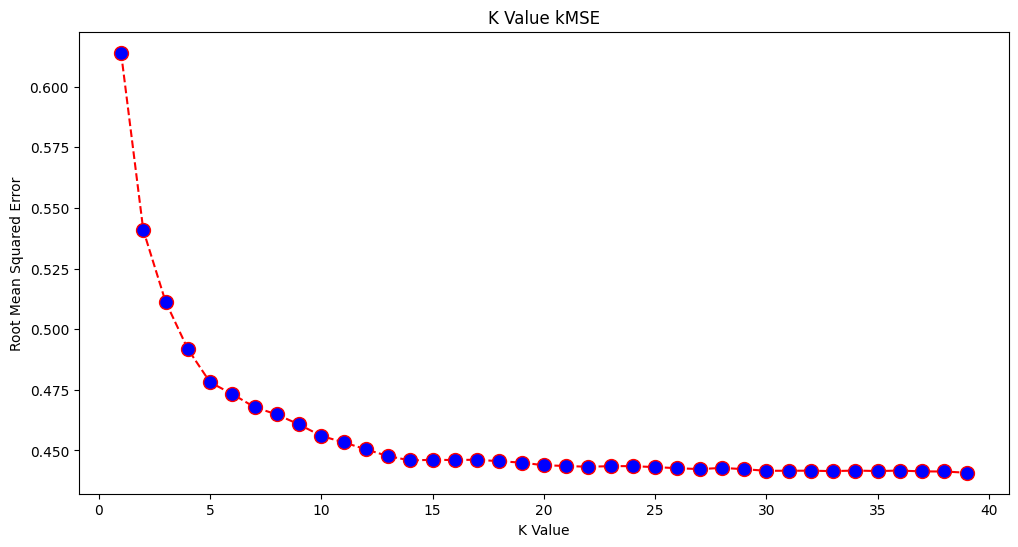

In [41]:
knn()

In [42]:
def regression(n):
# Create regressor
    clf = KNeighborsRegressor(8)
    # Fit on the training set
    clf.fit(x_train, y_train)
    # Create predictions
    pred = clf.predict(x_test)
    # Print the accuracy and root mean square error
    acc = clf.score(x_test,y_test)
    rmse = metrics.mean_squared_error(y_test, pred, squared = False)
    return(clf, acc, rmse)

In [43]:
regression(8)

(KNeighborsRegressor(n_neighbors=8), -0.08951912165577824, 0.46481075858669096)

In [44]:
def decision_tree_grid_search(data, param_grid):
    """returns the parameters that give the best result among the ones in your param_grid"""
    y = data['gravite_accident']
    X = data.drop('gravite_accident', axis = 1)
    regressor = tree.DecisionTreeRegressor()
    grid = GridSearchCV(regressor, param_grid = param_grid, cv = 10,verbose = 1, n_jobs = -1)
    grid.fit(X,y)
    return grid.best_params_

def Decision_Tree(X_train, X_test, y_train, y_test, max_depth, min_samples_leaf, min_samples_split):
    """returns RMSE and R2 for decision tree"""
    regressor = tree.DecisionTreeRegressor(
    max_depth = max_depth,
    min_samples_leaf = min_samples_leaf,
    min_samples_split = min_samples_split)
    regressor = regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = metrics.r2_score(y_test,y_pred)
    return regressor, R2, RMSE

In [45]:
param_grid = {'max_depth':[2,3,4,5,6,8,10,12],"min_samples_split": range(1,10), 'min_samples_leaf':range(1,5)}

#print(decision_tree_grid_search(df, param_grid))  

In [46]:
Decision_Tree(x_train, x_test, y_train, y_test, max_depth = 3, min_samples_leaf = 4, min_samples_split = 2)

(DecisionTreeRegressor(max_depth=3, min_samples_leaf=4),
 0.024582204892649395,
 0.4397988410477437)

In [47]:
def Grid_search(train, param_grid):
    """returns the parameters that give the best result among the ones in your param_grid"""    
    # Create the parameter grid based on the results of random search 
    y = train['gravite_accident']
    X = train.drop('gravite_accident', axis = 1)
    # Create a based model
    rf = RandomForestRegressor()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                            cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X, y)
    return grid_search.best_params_

def Random_Forest(X_train, X_test, y_train, y_test, max_depth, max_features, n_estimators):
    """returns RMSE and R2 for random forest"""
    regressor = RandomForestRegressor(bootstrap = True,
                max_depth = max_depth,
                max_features = max_features,
                n_estimators = n_estimators)
    regressor = regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = metrics.r2_score(y_test,y_pred)
    return regressor, R2, RMSE


param_grid = {
        'max_depth': [44, 45, 46, 47, 48, 49],
        'n_estimators': [850, 875, 900, 925]
    }

In [48]:
#Grid_search(df, param_grid)

In [49]:
Random_Forest(x_train, x_test, y_train, y_test, max_depth = 48, max_features = 'sqrt', n_estimators = 900)

(RandomForestRegressor(max_depth=48, max_features='sqrt', n_estimators=900),
 -0.1041755192156173,
 0.46792667155370105)

In [50]:
# Ecrire fonction pour prédire une gravité à partir d'un modèle fixé (donc prendre avant le one hot etc)
# Faire vis avec la répartition piste_cyclable

### Predictions

In [52]:
one_hot = ["luminosite", "type_route", "conditions_atmosperiques",
           "categorie_usager", "sexe", "arrondissement", "piste_cyclable"]
           
def prediction(regressor, features:list):
   # one hot encode features
   x_val = pd.DataFrame(features, columns=["jour", 'luminosite', 'conditions_atmosperiques', 'type_route',
       'nb_voies', 'categorie_usager', 'sexe', 'age',
       'piste_cyclable', "arrondissement"])
   
   y_pred = regressor.predict(x_val)
   print("La gravité prédite de l'accident, allant de 0 (Blessé léger) à 3 (Tué) est de {}".y_pred)

## Analyse paramètres à risques

In [100]:
df.head()

,jour,nb_voies,gravite_accident,age,luminosite_Crépuscule ou aube,luminosite_Nuit avec éclairage public allumé,luminosite_Nuit avec éclairage public non allumé,luminosite_Nuit sans éclairage public,luminosite_Plein jour,type_route_Autre,...,arrondissement_13,arrondissement_14,arrondissement_15,arrondissement_16,arrondissement_17,arrondissement_18,arrondissement_19,arrondissement_20,piste_cyclable_False,piste_cyclable_True
Unnamed:_0,,,,,,,,,,,,,,,,,,,,,
200500004591,1,2.0,1.0,36.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
200500004597,0,3.0,0.0,26.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
200500004600,0,4.0,0.0,31.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
200500004627,2,2.0,1.0,57.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
200500004630,2,4.0,1.0,26.0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0


In [126]:
columnsOHE=['luminosite_Crépuscule ou aube',
       'luminosite_Nuit avec éclairage public allumé',
       'luminosite_Nuit avec éclairage public non allumé',
       'luminosite_Nuit sans éclairage public', 'luminosite_Plein jour',
       'type_route_Autre', 'type_route_Hors réseau public',
       'type_route_Parc de stationnement ouvert à la circulation publique',
       'type_route_Route Départementale', 'type_route_Route Nationale',
       'type_route_Voie Communale', 'conditions_atmosperiques_Autre',
       'conditions_atmosperiques_Brouillard - fumée',
       'conditions_atmosperiques_Neige - grêle',
       'conditions_atmosperiques_Normale',
       'conditions_atmosperiques_Pluie forte',
       'conditions_atmosperiques_Pluie légère',
       'conditions_atmosperiques_Temps couvert',
       'conditions_atmosperiques_Temps éblouissant',
       'conditions_atmosperiques_Vent fort - tempête',
       'categorie_usager_Conducteur', 'categorie_usager_Passager',
       'categorie_usager_Piéton',
       'categorie_usager_Piéton en roller ou en trottinette', 'sexe_F',
       'sexe_M', 'arrondissement_01', 'arrondissement_02', 'arrondissement_03',
       'arrondissement_04', 'arrondissement_05', 'arrondissement_06',
       'arrondissement_07', 'arrondissement_08', 'arrondissement_09',
       'arrondissement_10', 'arrondissement_11', 'arrondissement_12',
       'arrondissement_13', 'arrondissement_14', 'arrondissement_15',
       'arrondissement_16', 'arrondissement_17', 'arrondissement_18',
       'arrondissement_19', 'arrondissement_20', 'piste_cyclable_False',
       'piste_cyclable_True']

def importance_OHE_columns():
   
    liste_moyennes=[]
    for x in columnsOHE:
        moyenne0=df[df[x]==0].loc[:,"gravite_accident"].mean()
        moyenne1=df[df[x]==1].loc[:,"gravite_accident"].mean()
        liste_moyennes.append([x,float(moyenne0),float(moyenne1)])
    liste_moyennes=np.array(liste_moyennes)

    return liste_moyennes
        



C:\Users\USER\AppData\Local\Temp\ipykernel_10484\1974827346.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(axisX,z[:,1].astype(np.float))
C:\Users\USER\AppData\Local\Temp\ipykernel_10484\1974827346.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(axisX,z[:,2].astype(np.float))


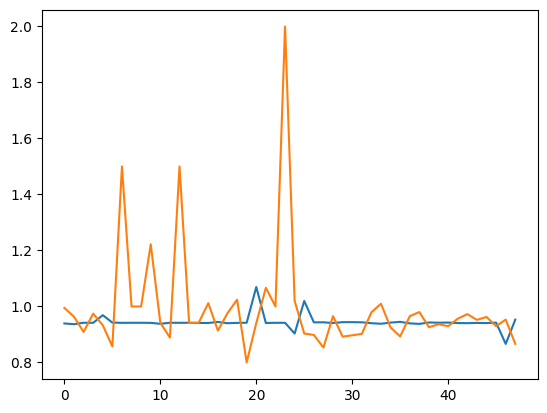

In [123]:
z=importance_OHE_columns()

axisX=[k for k in range(len(z[:,0]))]


plt.plot(axisX,z[:,1].astype(np.float))
plt.plot(axisX,z[:,2].astype(np.float))
plt.show()

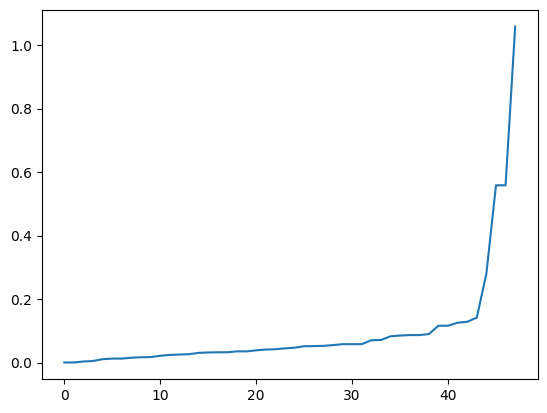

In [129]:

ecarts=[]
for k in range(len(z)):
    ecarts.append(abs(float(z[k,2])-float(z[k,1])))

#sorting ecarts et categ
def bubbleSort(arr,label):
     
    n = len(arr)
 
    # For loop to traverse through all
    # element in an array
    for i in range(n):
        for j in range(0, n - i - 1):
             
            # Range of the array is from 0 to n-i-1
            # Swap the elements if the element found
            #is greater than the adjacent element
            if arr[j] > arr[j + 1]:
                arr[j], arr[j + 1] = arr[j + 1], arr[j]
                label[j], label[j + 1] = label[j + 1], label[j]

columnsOHE2=columnsOHE[:]
bubbleSort(ecarts,columnsOHE2)

plt.plot(axisX,ecarts)
plt.show()




On compte donc un certain nombre de paramètres favorisant la gravité des accidents (grand écart entre un one hot ending true ou false)

In [133]:
print(ecarts[44:])
print(columnsOHE2[44:])

[0.2807190314871715, 0.5583303813909553, 0.5584622652651471, 1.058323494687131]
['type_route_Route Nationale', 'conditions_atmosperiques_Brouillard - fumée', 'type_route_Hors réseau public', 'categorie_usager_Piéton en roller ou en trottinette']
